In [1]:
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
import xgboost
from sklearn import preprocessing, linear_model, ensemble, metrics
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [3]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers, models, optimizers
from keras.layers import LSTM
from keras.layers.merge import concatenate
from keras.utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


# 准备文本

## abstract

In [246]:
abs_filepath = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/model/abstract/abstract-ep008-loss0.623-val_loss0.611.h5.xlsx"
abstract = pd.read_excel(abs_filepath, encoding='utf-8')

In [247]:
abstract.shape

(7769, 72)

In [248]:
x_abs = abstract
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_abs, p=None)
c

12.539779837277795

## claims

In [611]:
claim_filepath = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/model/claims/claims-ep007-loss0.627-val_loss0.615.h5.xlsx"
claims = pd.read_excel(claim_filepath, encoding='utf-8')

In [612]:
claims.shape

(7769, 72)

In [613]:
x_claims = claims
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_claims, p=None)
c

16.866100239214042

## text_sum

In [725]:
sum_feature = pd.concat([abstract,claims],  axis=1, ignore_index=True)

In [726]:
sum_feature.shape

(7769, 144)

In [727]:
x_text = sum_feature
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_text, p=None)
c

20.333224087368134

## fusion

In [247]:
text_filepath = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/model/fusion/fusion-ep039-loss0.610-val_loss0.616.h5.xlsx"
fusion_feature = pd.read_excel(text_filepath, encoding='utf-8')

In [248]:
fusion_feature.shape

(7769, 72)

In [249]:
x_fusion = fusion_feature
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_fusion, p=None)
c

55.96842562648369

## result

In [8]:
data = pd.read_excel("/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/2010_result.xlsx", encoding='utf-8')

In [9]:
result = data['result']

In [10]:
train_target = np_utils.to_categorical(data[['result']], 2)
y_ints = [y.argmax() for y in train_target]
cw = class_weight.compute_class_weight('balanced', np.unique(y_ints), y_ints)
cw

array([1.49346405, 0.75164474])

In [11]:
train_target.shape

(7769, 2)

## node

In [328]:
node_file = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/ActiveHNE/data/0-38.xlsx"
node = pd.read_excel(node_file, encoding='utf-8', header=None)

In [329]:
node.shape

(7769, 72)

In [854]:
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(node, p=None)
c

628.868669815647

In [330]:
node = node/100

## node_text

In [922]:
node_text = pd.concat([sum_feature, node],  axis=1, ignore_index=True)
node_text.shape

(7769, 216)

In [923]:
node_text_c = np.linalg.cond(node_text, p=None)
print("node_text= {:.4f}".format(node_text_c))

node_text= 1034.9294


## node_fusion

In [331]:
node_fusion = pd.concat([fusion_feature, node],  axis=1, ignore_index=True)
node_fusion.shape

(7769, 144)

In [332]:
node_fusion_c = np.linalg.cond(node_fusion, p=None)
print("node_text= {:.4f}".format(node_fusion_c))

node_text= 792.3750


## 归一化or标准化处理

In [23]:
x_abs = preprocessing.scale(x_abs)
# node_text = preprocessing.minmax_scale(node_text)

In [329]:
x_claims = preprocessing.scale(x_claims)
# node_text = preprocessing.minmax_scale(node_text)

In [248]:
x_text = preprocessing.scale(x_text)
# node_text = preprocessing.minmax_scale(node_text)

In [ ]:
x_fusion = preprocessing.scale(x_fusion)
# x_fusion = preprocessing.minmax_scale(x_fusion)

In [856]:
node = preprocessing.scale(node)
# node_text = preprocessing.minmax_scale(node_text)

In [924]:
node_text = preprocessing.scale(node_text)
# node_text = preprocessing.minmax_scale(node_text)

# 划分训练集

In [434]:
x_abs_train = x_abs[:6215]
x_abs_valid = x_abs[6215:6992]
x_abs_test = x_abs[6992:]

In [614]:
x_claims_train = x_claims[:6215]
x_claims_valid = x_claims[6215:6992]
x_claims_test = x_claims[6992:]

In [729]:
x_text_train = x_text[:6215]
x_text_valid = x_text[6215:6992]
x_text_test = x_text[6992:]

In [250]:
x_fusion_train = x_fusion[:6215]
x_fusion_valid = x_fusion[6215:6992]
x_fusion_test = x_fusion[6992:]

In [857]:
x_node_train = node[:6215]
x_node_valid = node[6215:6992]
x_node_test = node[6992:]

In [925]:
node_text_train = node_text[:6215]
node_text_valid = node_text[6215:6992]
node_text_test = node_text[6992:]

In [333]:
node_fusion_train = node_fusion[:6215]
node_fusion_valid = node_fusion[6215:6992]
node_fusion_test = node_fusion[6992:]

In [13]:
y_binary_train = result[:6215]
y_binary_valid = result[6215:6992]
y_binary_test = result[6992:]

y_category_train = train_target[:6215]
y_category_valid = train_target[6215:6992]
y_category_test = train_target[6992:]

In [14]:
sum(y_category_train[:,1])/sum(y_category_train[:,0])

1.9765325670498084

# 机器学习分类

In [15]:
def train_model(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    
    y_predict = classifier.predict(x_test)# 每一个x的预测值
    y_predict_proba = classifier.predict_proba(x_test) # 预测分类的概率
    
    precision = metrics.precision_score(y_test, y_predict) # 精确率
    recall = metrics.recall_score(y_test, y_predict) # 召回率
    f1 = metrics.f1_score(y_test, y_predict) # f1
    accuracy = metrics.accuracy_score(y_test, y_predict, normalize = True) # 准确率
    
    # print("accuracy: {:.4f} precision: {:.4f} recall: {:.4f} f1: {:.4f}".format(accuracy,precision,recall,f1))
    
    return y_predict,y_predict_proba

## abstract

In [308]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, penalty='l2', class_weight="balanced", C=0.005, fit_intercept=True),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=50), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.1, n_estimators=30)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [309]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_abs_train, y_binary_train, x_abs_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:28<00:00,  9.58s/it]


In [310]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [311]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list, dtype=float)
acc = np.mean(LR_metrics_arrat[:, 0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:, 1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:, 2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:, 0].tolist())
print(LR_metrics_arrat[:, 1].tolist())
print(LR_metrics_arrat[:, 2].tolist())

LR acc:  0.6229
LR macro:  0.6025
LR weighted:  0.6314
[0.6229]
[0.6025]
[0.6314]


In [312]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.4570    0.5833    0.5125       264
           1     0.7500    0.6433    0.6925       513

    accuracy                         0.6229       777
   macro avg     0.6035    0.6133    0.6025       777
weighted avg     0.6504    0.6229    0.6314       777



In [313]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.6602
RF macro:  0.5385
RF weighted:  0.6145
[0.6602]
[0.5385]
[0.6145]


In [314]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.5000    0.2159    0.3016       264
           1     0.6878    0.8889    0.7755       513

    accuracy                         0.6602       777
   macro avg     0.5939    0.5524    0.5385       777
weighted avg     0.6240    0.6602    0.6145       777



In [315]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.6113
XGB macro:  0.5863
XGB weighted:  0.6189
[0.6602]
[0.5385]
[0.6145]


In [316]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.4410    0.5379    0.4846       264
           1     0.7319    0.6491    0.6880       513

    accuracy                         0.6113       777
   macro avg     0.5864    0.5935    0.5863       777
weighted avg     0.6330    0.6113    0.6189       777



## claims

In [715]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, penalty='l2', class_weight="balanced", C=0.001, fit_intercept=False),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=50), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.15, n_estimators=40)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [716]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_claims_train, y_binary_train, x_claims_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:22<00:00,  7.57s/it]


In [717]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [720]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.6255
LR macro:  0.6017
LR weighted:  0.6329
[0.6255]
[0.6017]
[0.6329]


In [721]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.4582    0.5606    0.5043       264
           1     0.7445    0.6589    0.6991       513

    accuracy                         0.6255       777
   macro avg     0.6013    0.6097    0.6017       777
weighted avg     0.6472    0.6255    0.6329       777



In [718]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.6757
RF macro:  0.5445
RF weighted:  0.6228
[0.6757]
[0.5445]
[0.6228]


In [719]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.5625    0.2045    0.3000       264
           1     0.6916    0.9181    0.7889       513

    accuracy                         0.6757       777
   macro avg     0.6271    0.5613    0.5445       777
weighted avg     0.6478    0.6757    0.6228       777



In [722]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.6371
XGB macro:  0.6088
XGB weighted:  0.6425
[0.6757]
[0.5445]
[0.6228]


In [723]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.4704    0.5417    0.5035       264
           1     0.7442    0.6862    0.7140       513

    accuracy                         0.6371       777
   macro avg     0.6073    0.6139    0.6088       777
weighted avg     0.6512    0.6371    0.6425       777



## text_sum

In [782]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, penalty='l2', class_weight="balanced", C=0.001, fit_intercept=False),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=100), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.1, n_estimators=100)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [783]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_text_train, y_binary_train, x_text_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [01:34<00:00, 31.40s/it]


In [784]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [774]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.6293
LR macro:  0.6060
LR weighted:  0.6367
[0.6293]
[0.606]
[0.6367]


In [778]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.4630    0.5682    0.5102       264
           1     0.7483    0.6608    0.7019       513

    accuracy                         0.6293       777
   macro avg     0.6057    0.6145    0.6060       777
weighted avg     0.6514    0.6293    0.6367       777



In [785]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.6847
RF macro:  0.5597
RF weighted:  0.6349
[0.6847]
[0.5597]
[0.6349]


In [788]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.5960    0.2235    0.3251       264
           1     0.6976    0.9220    0.7943       513

    accuracy                         0.6847       777
   macro avg     0.6468    0.5728    0.5597       777
weighted avg     0.6631    0.6847    0.6349       777



In [786]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(XGB_metrics_arrat[:,0].tolist())
print(XGB_metrics_arrat[:,1].tolist())
print(XGB_metrics_arrat[:,2].tolist())

XGB acc:  0.6268
XGB macro:  0.5913
XGB weighted:  0.6299
[0.6268]
[0.5913]
[0.6299]


In [789]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.4630    0.5682    0.5102       264
           1     0.7483    0.6608    0.7019       513

    accuracy                         0.6293       777
   macro avg     0.6057    0.6145    0.6060       777
weighted avg     0.6514    0.6293    0.6367       777



## fusion

In [321]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, penalty='l2', class_weight="balanced", C=0.15, fit_intercept=False),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=30), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.15, n_estimators=30)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [322]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_fusion_train, y_binary_train, x_fusion_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:04<00:00,  1.48s/it]


In [323]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [302]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.6319
LR macro:  0.6127
LR weighted:  0.6404
[0.6319]
[0.6127]
[0.6404]


In [303]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.4676    0.6023    0.5265       264
           1     0.7597    0.6472    0.6989       513

    accuracy                         0.6319       777
   macro avg     0.6137    0.6247    0.6127       777
weighted avg     0.6605    0.6319    0.6404       777



In [324]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.6564
RF macro:  0.5483
RF weighted:  0.6191
[0.6564]
[0.5483]
[0.6191]


In [325]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.4887    0.2462    0.3275       264
           1     0.6910    0.8674    0.7692       513

    accuracy                         0.6564       777
   macro avg     0.5899    0.5568    0.5483       777
weighted avg     0.6223    0.6564    0.6191       777



In [260]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(XGB_metrics_arrat[:,0].tolist())
print(XGB_metrics_arrat[:,1].tolist())
print(XGB_metrics_arrat[:,2].tolist())

XGB acc:  0.6178
XGB macro:  0.5940
XGB weighted:  0.6255
[0.6178]
[0.594]
[0.6255]


In [261]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.4492    0.5530    0.4958       264
           1     0.7389    0.6511    0.6922       513

    accuracy                         0.6178       777
   macro avg     0.5941    0.6021    0.5940       777
weighted avg     0.6405    0.6178    0.6255       777



## node

In [899]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, penalty='l2', max_iter=1000, class_weight="balanced", C=0.1, fit_intercept=True),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=100), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.15, n_estimators=100)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [900]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_node_train, y_binary_train, x_node_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [01:12<00:00, 24.07s/it]


In [901]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [902]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.7194
LR macro:  0.7136
LR weighted:  0.7267
[0.7194]
[0.7136]
[0.7267]


In [903]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.5572    0.8485    0.6727       264
           1     0.8933    0.6530    0.7545       513

    accuracy                         0.7194       777
   macro avg     0.7253    0.7508    0.7136       777
weighted avg     0.7791    0.7194    0.7267       777



In [904]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.7452
RF macro:  0.7016
RF weighted:  0.7381
[0.7452]
[0.7016]
[0.7381]


In [907]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.6528    0.5341    0.5875       264
           1     0.7807    0.8538    0.8156       513

    accuracy                         0.7452       777
   macro avg     0.7168    0.6939    0.7016       777
weighted avg     0.7373    0.7452    0.7381       777



In [908]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.7387
XGB macro:  0.7249
XGB weighted:  0.7447
[0.7452]
[0.7016]
[0.7381]


In [909]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.5900    0.7576    0.6633       264
           1     0.8539    0.7290    0.7865       513

    accuracy                         0.7387       777
   macro avg     0.7219    0.7433    0.7249       777
weighted avg     0.7642    0.7387    0.7447       777



## node_text

In [983]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, max_iter=1500, penalty='l2', class_weight="balanced", C=0.01, fit_intercept=True),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=80), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.1, n_estimators=100)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [984]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(node_text_train, y_binary_train, node_text_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:40<00:00, 13.52s/it]


In [985]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [986]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.7452
LR macro:  0.7299
LR weighted:  0.7505
[0.7452]
[0.7299]
[0.7505]


In [987]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.6006    0.7462    0.6655       264
           1     0.8508    0.7446    0.7942       513

    accuracy                         0.7452       777
   macro avg     0.7257    0.7454    0.7299       777
weighted avg     0.7658    0.7452    0.7505       777



In [988]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.7812
RF macro:  0.7438
RF weighted:  0.7752
[0.7812]
[0.7438]
[0.7752]


In [989]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.7176    0.5871    0.6458       264
           1     0.8057    0.8811    0.8417       513

    accuracy                         0.7812       777
   macro avg     0.7616    0.7341    0.7438       777
weighted avg     0.7758    0.7812    0.7752       777



In [990]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.7658
XGB macro:  0.7482
XGB weighted:  0.7695
[0.7812]
[0.7438]
[0.7752]


In [991]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.6331    0.7386    0.6818       264
           1     0.8529    0.7797    0.8147       513

    accuracy                         0.7658       777
   macro avg     0.7430    0.7592    0.7482       777
weighted avg     0.7782    0.7658    0.7695       777



## node_fusion

In [488]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, max_iter=1500, penalty='l2', class_weight="balanced", C=0.99, fit_intercept=True),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=10), # 155
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.1, n_estimators=35)] # 30

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [489]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(node_fusion_train, y_binary_train, node_fusion_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:07<00:00,  2.60s/it]


In [490]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [397]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.7748
LR macro:  0.7635
LR weighted:  0.7800
[0.7748]
[0.7635]
[0.78]


In [387]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.6290    0.8220    0.7126       264
           1     0.8912    0.7505    0.8148       513

    accuracy                         0.7748       777
   macro avg     0.7601    0.7862    0.7637       777
weighted avg     0.8021    0.7748    0.7801       777



In [468]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.7735
RF macro:  0.7335
RF weighted:  0.7666
[0.7735]
[0.7335]
[0.7666]


In [469]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.7075    0.5682    0.6303       264
           1     0.7982    0.8791    0.8367       513

    accuracy                         0.7735       777
   macro avg     0.7529    0.7237    0.7335       777
weighted avg     0.7674    0.7735    0.7666       777



In [491]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.7580
XGB macro:  0.7442
XGB weighted:  0.7633
[0.7735]
[0.7335]
[0.7666]


In [492]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.6145    0.7727    0.6846       264
           1     0.8652    0.7505    0.8038       513

    accuracy                         0.7580       777
   macro avg     0.7398    0.7616    0.7442       777
weighted avg     0.7800    0.7580    0.7633       777



## 绘图

100%|█| 3/3 [00:00<0


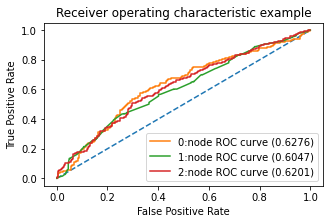

In [318]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


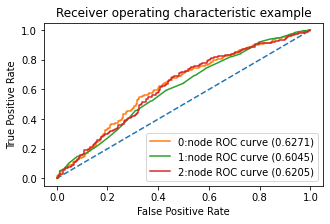

In [728]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


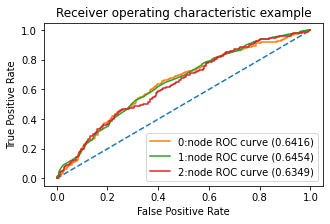

In [790]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


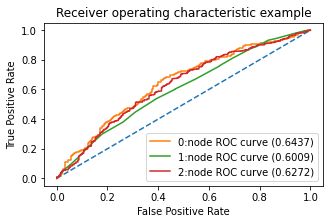

In [326]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


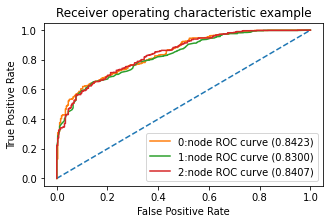

In [910]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


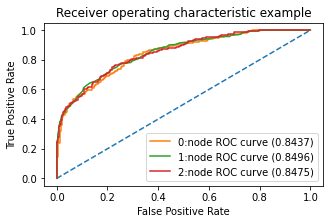

In [992]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


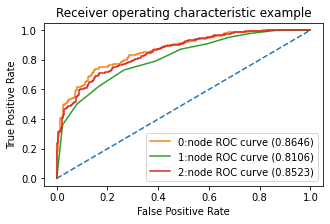

In [493]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 神经网络分类

In [196]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [791]:
def full_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))

    Dense_layer_1 = layers.Dense(152, activation="relu")(input_layer)
    Dense_layer_2 = layers.Dense(64, activation="relu")(Dense_layer_1)
    dropout_layer = layers.Dropout(0.35)(Dense_layer_2)
    Dense_layer_3 = layers.Dense(2, activation='softmax')(dropout_layer)

    model = models.Model(inputs=input_layer, outputs=Dense_layer_3)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()

    return model

In [912]:
def full_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))

    Dense_layer_1 = layers.Dense(80, activation="relu")(input_layer)
    Dense_layer_2 = layers.Dense(48, activation="relu")(Dense_layer_1)
    dropout_layer = layers.Dropout(0.4)(Dense_layer_2)
    Dense_layer_3 = layers.Dense(2, activation='softmax')(dropout_layer)

    model = models.Model(inputs=input_layer, outputs=Dense_layer_3)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()

    return model

In [415]:
def full_lstm_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    input_layer_1 = layers.Lambda(lambda input_layer:K.expand_dims(input_layer, axis=-1))(input_layer)
    lstm_layer = layers.Bidirectional(LSTM(128, return_sequences=False))(input_layer_1)
    Dropout_layer = layers.Dropout(0.4)(lstm_layer)
    Dense_layer_1 = layers.Dense(72, activation="relu")(Dropout_layer)
    Dropout_layer = layers.Dropout(0.4)(Dense_layer_1)
    Dense_layer_1 = layers.Dense(2, activation='softmax')(Dropout_layer)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_1)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [419]:
def full_lstm_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    input_layer_1 = layers.Lambda(lambda input_layer:K.expand_dims(input_layer, axis=-1))(input_layer)
    lstm_layer = layers.Bidirectional(LSTM(128, return_sequences=False))(input_layer_1)
    Dropout_layer = layers.Dropout(0.3)(lstm_layer)
    Dense_layer_1 = layers.Dense(72, activation="relu")(Dropout_layer)
    Dropout_layer = layers.Dropout(0.4)(Dense_layer_1)
    Dense_layer_1 = layers.Dense(2, activation='softmax')(Dropout_layer)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_1)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [423]:
def full_lstm_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    input_layer_1 = layers.Lambda(lambda input_layer:K.expand_dims(input_layer, axis=-1))(input_layer)
    lstm_layer = layers.Bidirectional(LSTM(144, return_sequences=False))(input_layer_1)
    Dropout_layer = layers.Dropout(0.4)(lstm_layer)
    Dense_layer_1 = layers.Dense(72, activation="relu")(Dropout_layer)
    Dropout_layer = layers.Dropout(0.4)(Dense_layer_1)
    Dense_layer_1 = layers.Dense(2, activation='softmax')(Dropout_layer)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_1)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [427]:
def full_lstm_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    input_layer_1 = layers.Lambda(lambda input_layer:K.expand_dims(input_layer, axis=-1))(input_layer)
    lstm_layer = layers.Bidirectional(LSTM(144, return_sequences=False))(input_layer_1)
    Dropout_layer = layers.Dropout(0.3)(lstm_layer)
    Dense_layer_1 = layers.Dense(72, activation="relu")(Dropout_layer)
    Dropout_layer = layers.Dropout(0.4)(Dense_layer_1)
    Dense_layer_1 = layers.Dense(2, activation='softmax')(Dropout_layer)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_1)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [278]:
def full_lstm_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    input_layer_1 = layers.Lambda(lambda input_layer:K.expand_dims(input_layer, axis=-1))(input_layer)
    lstm_layer = layers.Bidirectional(LSTM(76, return_sequences=False))(input_layer_1)
    dropout_layer = layers.Dropout(0.3)(lstm_layer)
    Dense_layer_1 = layers.Dense(48, activation="relu")(dropout_layer)
    Dropout_layer = layers.Dropout(0.4)(Dense_layer_1)
    Dense_layer_1 = layers.Dense(2, activation='softmax')(Dropout_layer)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_1)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [913]:
# 提前停止监视器设置为3，这意味着在连续3次运行后，模型的性能没有改进的话，训练将会被停止
my_callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=10)]

In [914]:
history_list = []
model_list = []

for i in tqdm(range(1), ncols=70):
    model = full_connect_network(x_node_train.shape[1])
    history = model.fit(x_node_train, y_category_train, 
                        validation_data=(x_node_valid, y_category_valid), 
                        verbose=0, epochs=100, batch_size=256, shuffle=False,
                        callbacks=my_callbacks)
    history_list.append(history)
    model_list.append(model)

100%|███████████████████████████████████| 1/1 [00:10<00:00, 10.79s/it]


In [915]:
metrics_list = []
roc_list = []

for model in tqdm(model_list, ncols=70):
    y_pred = model.predict(x_node_test, batch_size=256, verbose=0)
    y_pred_proba = np.array(y_pred, dtype=float)
    y_pred_proba = y_pred_proba[:,1]
    fpr, tpr, _  =  roc_curve(y_binary_test, list(y_pred_proba))
    roc_list.append(auc(fpr,tpr))

    for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0
    report = classification_report(y_category_test, y_pred, digits=4)
    p = re.compile('  |\n', re.S)
    report = p.sub(' ', report)
    metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
    metrics_list.append(metrics_content)

100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


## abstract

In [423]:
# abstract
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.6384
NN macro:  0.4988
NN weighted:  0.5836
[0.6384]
[0.4988]
[0.5836]
NN roc:  0.6093


In [424]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.4175    0.1629    0.2343       264
           1     0.6721    0.8830    0.7633       513

   micro avg     0.6384    0.6384    0.6384       777
   macro avg     0.5448    0.5230    0.4988       777
weighted avg     0.5856    0.6384    0.5836       777
 samples avg     0.6384    0.6384    0.6384       777



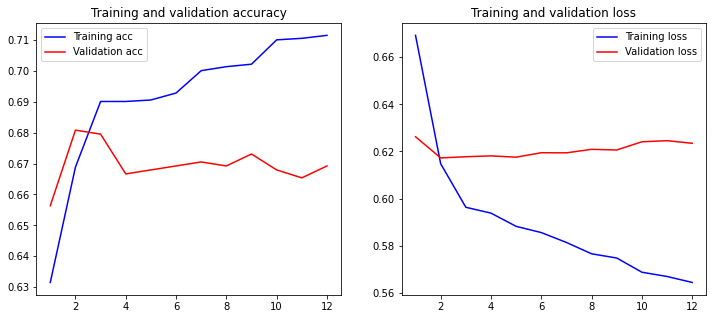

In [425]:
plot_history(history_list[0])

## claims

In [587]:
# claims
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.6564
NN macro:  0.5453
NN weighted:  0.6173
[0.6564]
[0.5453]
[0.6173]
NN roc:  0.6150


In [448]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5385    0.1856    0.2761       264
           1     0.6866    0.9181    0.7857       513

   micro avg     0.6692    0.6692    0.6692       777
   macro avg     0.6125    0.5519    0.5309       777
weighted avg     0.6363    0.6692    0.6125       777
 samples avg     0.6692    0.6692    0.6692       777



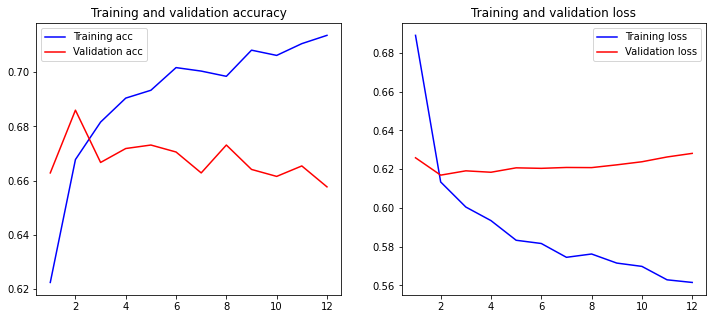

In [588]:
plot_history(history_list[0])

## text_sum

In [795]:
# sum
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.6551
NN macro:  0.5459
NN weighted:  0.6173
[0.6551]
[0.5459]
[0.6173]
NN roc:  0.6092


In [796]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.4848    0.2424    0.3232       264
           1     0.6899    0.8674    0.7686       513

   micro avg     0.6551    0.6551    0.6551       777
   macro avg     0.5874    0.5549    0.5459       777
weighted avg     0.6202    0.6551    0.6173       777
 samples avg     0.6551    0.6551    0.6551       777



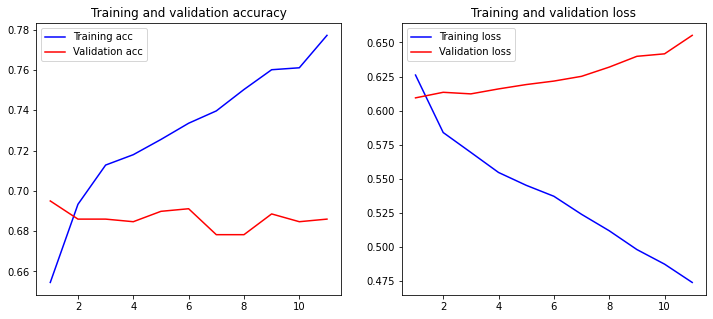

In [797]:
plot_history(history_list[0])

## fusion

In [244]:
# fusion
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.6662
NN macro:  0.5493
NN weighted:  0.6228
[0.668, 0.6705, 0.6667, 0.6615, 0.6641]
[0.5569, 0.5541, 0.5448, 0.5411, 0.5494]
[0.628, 0.6271, 0.6203, 0.6164, 0.6223]
NN roc:  0.6368


In [ ]:
print(classification_report(y_category_test, y_pred, digits=4))

In [ ]:
plot_history(history_list[0])

## node

In [916]:
# node
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.7851
NN macro:  0.7319
NN weighted:  0.7702
[0.7851]
[0.7319]
[0.7702]
NN roc:  0.8463


In [917]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7904    0.5000    0.6125       264
           1     0.7836    0.9318    0.8513       513

   micro avg     0.7851    0.7851    0.7851       777
   macro avg     0.7870    0.7159    0.7319       777
weighted avg     0.7859    0.7851    0.7702       777
 samples avg     0.7851    0.7851    0.7851       777



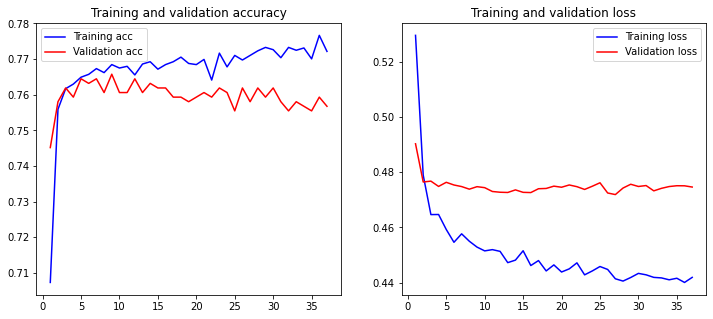

In [918]:
plot_history(history_list[0])

## node+text

In [396]:
# node+text+Dense
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))
print(roc_list)

NN acc:  0.7707
NN macro:  0.7336
NN weighted:  0.7654
[0.7709, 0.7645, 0.7735, 0.7658, 0.7786]
[0.737, 0.7293, 0.7347, 0.7263, 0.7408]
[0.7673, 0.7606, 0.7672, 0.7596, 0.7725]
NN roc:  0.8295
[0.8287627739382125, 0.8331118199539251, 0.8307785456908263, 0.8281056175793018, 0.8265697914820722]


In [333]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7005    0.5492    0.6157       264
           1     0.7912    0.8791    0.8329       513

   micro avg     0.7671    0.7671    0.7671       777
   macro avg     0.7459    0.7142    0.7243       777
weighted avg     0.7604    0.7671    0.7591       777
 samples avg     0.7671    0.7671    0.7671       777



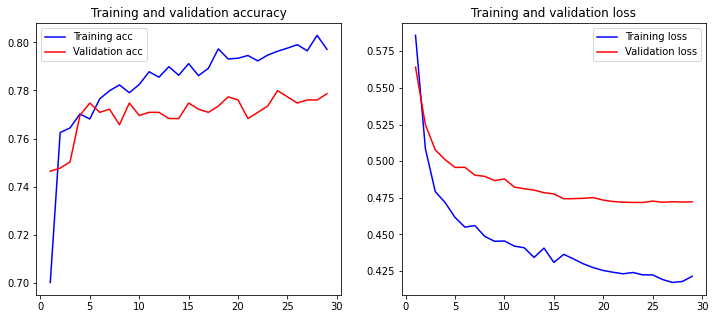

In [334]:
plot_history(history_list[0])

In [418]:
# node+text+BiLSTM
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.7696
NN macro:  0.7338
NN weighted:  0.7651
[0.7671, 0.7773, 0.7709, 0.7696, 0.7632]
[0.7334, 0.743, 0.7353, 0.7341, 0.7233]
[0.7638, 0.7731, 0.7664, 0.7652, 0.757]
NN roc:  0.8303


In [422]:
# node+text+BiLSTM
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.7704
NN macro:  0.7302
NN weighted:  0.7636
[0.7683, 0.7735, 0.7696, 0.7722, 0.7683]
[0.7305, 0.7341, 0.7293, 0.7371, 0.7199]
[0.7629, 0.7669, 0.7628, 0.7679, 0.7573]
NN roc:  0.8314


In [426]:
# node+text+BiLSTM
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.7717
NN macro:  0.7092
NN weighted:  0.7523
[0.7683, 0.7748, 0.7773, 0.7683, 0.7696]
[0.7089, 0.7123, 0.7358, 0.694, 0.6952]
[0.7511, 0.7553, 0.7694, 0.7423, 0.7435]
NN roc:  0.8347


In [430]:
# node+text+BiLSTM
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.7709
NN macro:  0.7000
NN weighted:  0.7467
[0.7683, 0.7748, 0.7748, 0.7683, 0.7683]
[0.695, 0.7114, 0.7059, 0.699, 0.6887]
[0.7429, 0.7548, 0.7515, 0.7453, 0.7392]
NN roc:  0.8347
